In [1]:
%load_ext autoreload
%autoreload 2

# Importy

In [2]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from utils import *

In [3]:
dataframes = read_csv("./datasets", 'csv')

In [4]:
res = prepare_dataframes(dataframes)

  0%|          | 0/3 [00:00<?, ?it/s]

out_hum
pressure
out_temp


In [5]:
df = get_labels(res, '2024-02-13')

In [6]:
df['rain_1h'] = df['rain_1h'].fillna(0)
df['snow_1h'] = df['snow_1h'].fillna(0)
df['total percipitation'] = df['rain_1h'] + df['snow_1h']

In [7]:
df['last_changed_count'] = df.groupby('last_changed')['last_changed'].transform('count')
df = df.drop_duplicates(subset=['last_changed'])
df = df.loc[:, ['last_changed', 'pressure', 'out_temp', 'out_hum', 'total percipitation']]
df = df.reset_index(drop=True)

## Tabela 1 (time, P, T, H, R)

In [8]:
df

,last_changed,pressure,out_temp,out_hum,total percipitation
0,2023-09-20 00:00:00+00:00,986.000000,15.300000,76.000000,0.00
1,2023-09-20 01:00:00+00:00,985.428571,14.528571,78.900000,0.00
2,2023-09-20 02:00:00+00:00,985.760000,14.212500,79.500000,0.00
3,2023-09-20 03:00:00+00:00,985.280000,14.041667,81.300000,0.00
4,2023-09-20 04:00:00+00:00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...
3499,2024-02-12 19:00:00+00:00,974.777778,7.220000,85.166667,0.00
3500,2024-02-12 20:00:00+00:00,975.846154,7.020000,84.933333,0.00
3501,2024-02-12 21:00:00+00:00,976.846154,6.566667,84.033333,0.00
3502,2024-02-12 22:00:00+00:00,976.521739,6.370000,83.873913,0.00


In [9]:
df.value_counts('total percipitation')

total percipitation
0.00     2666
0.25      166
0.51      149
0.38       37
1.02       29
         ... 
1.53        1
1.59        1
1.61        1
1.66        1
30.99       1
Name: count, Length: 119, dtype: int64

## Tabela 2 (time, 0, -1, -2, -3...)

In [10]:
df2 = generate_data(df, 5)
df2

,time,TP t+1,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
0,2023-09-20 05:00:00+00:00,0.0,986.217391,13.966667,83.366667,0.0,985.666667,13.833333,83.333333,0.25,...,79.500000,0.00,985.428571,14.528571,78.900000,0.00,986.000000,15.300000,76.000000,0.00
1,2023-09-20 06:00:00+00:00,0.0,986.478261,14.640000,80.100000,0.0,986.217391,13.966667,83.366667,0.00,...,81.300000,0.00,985.760000,14.212500,79.500000,0.00,985.428571,14.528571,78.900000,0.00
2,2023-09-20 07:00:00+00:00,0.0,986.739130,15.480000,75.420000,0.0,986.478261,14.640000,80.100000,0.00,...,83.333333,0.25,985.280000,14.041667,81.300000,0.00,985.760000,14.212500,79.500000,0.00
3,2023-09-20 08:00:00+00:00,0.0,986.090909,17.000000,69.840000,0.0,986.739130,15.480000,75.420000,0.00,...,83.366667,0.00,985.666667,13.833333,83.333333,0.25,985.280000,14.041667,81.300000,0.00
4,2023-09-20 09:00:00+00:00,0.0,986.200000,18.600000,61.920000,0.0,986.090909,17.000000,69.840000,0.00,...,80.100000,0.00,986.217391,13.966667,83.366667,0.00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,2024-02-12 18:00:00+00:00,0.0,974.642857,7.371429,84.830000,0.0,973.500000,7.540000,84.800000,0.00,...,83.640000,0.00,971.652174,7.860000,85.928571,0.00,971.130435,7.955556,86.000000,0.00
3494,2024-02-12 19:00:00+00:00,0.0,974.777778,7.220000,85.166667,0.0,974.642857,7.371429,84.830000,0.00,...,83.020000,0.00,972.384615,7.877778,83.640000,0.00,971.652174,7.860000,85.928571,0.00
3495,2024-02-12 20:00:00+00:00,0.0,975.846154,7.020000,84.933333,0.0,974.777778,7.220000,85.166667,0.00,...,84.800000,0.00,973.222222,7.754545,83.020000,0.00,972.384615,7.877778,83.640000,0.00
3496,2024-02-12 21:00:00+00:00,0.0,976.846154,6.566667,84.033333,0.0,975.846154,7.020000,84.933333,0.00,...,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,83.020000,0.00


# DT (bez normalizacji danych)

In [11]:
X = df2.iloc[:,2:]
y = df2.iloc[:,1:2]

In [12]:
X

,Press t0,Temp t0,Hum t0,TP t0,Press t-1,Temp t-1,Hum t-1,TP t-1,Press t-2,Temp t-2,...,Hum t-3,TP t-3,Press t-4,Temp t-4,Hum t-4,TP t-4,Press t-5,Temp t-5,Hum t-5,TP t-5
0,986.217391,13.966667,83.366667,0.0,985.666667,13.833333,83.333333,0.25,985.280000,14.041667,...,79.500000,0.00,985.428571,14.528571,78.900000,0.00,986.000000,15.300000,76.000000,0.00
1,986.478261,14.640000,80.100000,0.0,986.217391,13.966667,83.366667,0.00,985.666667,13.833333,...,81.300000,0.00,985.760000,14.212500,79.500000,0.00,985.428571,14.528571,78.900000,0.00
2,986.739130,15.480000,75.420000,0.0,986.478261,14.640000,80.100000,0.00,986.217391,13.966667,...,83.333333,0.25,985.280000,14.041667,81.300000,0.00,985.760000,14.212500,79.500000,0.00
3,986.090909,17.000000,69.840000,0.0,986.739130,15.480000,75.420000,0.00,986.478261,14.640000,...,83.366667,0.00,985.666667,13.833333,83.333333,0.25,985.280000,14.041667,81.300000,0.00
4,986.200000,18.600000,61.920000,0.0,986.090909,17.000000,69.840000,0.00,986.739130,15.480000,...,80.100000,0.00,986.217391,13.966667,83.366667,0.00,985.666667,13.833333,83.333333,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,974.642857,7.371429,84.830000,0.0,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,...,83.640000,0.00,971.652174,7.860000,85.928571,0.00,971.130435,7.955556,86.000000,0.00
3494,974.777778,7.220000,85.166667,0.0,974.642857,7.371429,84.830000,0.00,973.500000,7.540000,...,83.020000,0.00,972.384615,7.877778,83.640000,0.00,971.652174,7.860000,85.928571,0.00
3495,975.846154,7.020000,84.933333,0.0,974.777778,7.220000,85.166667,0.00,974.642857,7.371429,...,84.800000,0.00,973.222222,7.754545,83.020000,0.00,972.384615,7.877778,83.640000,0.00
3496,976.846154,6.566667,84.033333,0.0,975.846154,7.020000,84.933333,0.00,974.777778,7.220000,...,84.830000,0.00,973.500000,7.540000,84.800000,0.00,973.222222,7.754545,83.020000,0.00


In [13]:
y

,TP t+1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
3493,0.0
3494,0.0
3495,0.0
3496,0.0


## Test 1: DT, min_samples_leaf

In [14]:
kfold = KFold(n_splits = 5)

classifiers = [    
    DecisionTreeRegressor(min_samples_leaf=10),
    DecisionTreeRegressor(min_samples_leaf=20),
    DecisionTreeRegressor(min_samples_leaf=50),
    DecisionTreeRegressor(min_samples_leaf=100),
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'min_samples_leaf': classifier.get_params().get('min_samples_leaf'),
        #'Degree': classifier.get_params().get('degree'),
        #'C': classifier.get_params().get('C'),
        #'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_dt_1 = pd.DataFrame(results_list)

  0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
df_dt_1

,Classifier,min_samples_leaf,r2,neg_mean_squared_error,neg_mean_absolute_error
0,DecisionTreeRegressor,10,-0.596813,-1.040282,-0.273474
1,DecisionTreeRegressor,20,-0.182426,-0.967534,-0.247751
2,DecisionTreeRegressor,50,-0.012537,-0.927418,-0.226515
3,DecisionTreeRegressor,100,0.073434,-0.905031,-0.242073


## Test 2: DT, min_samples_leaf

In [16]:
kfold = KFold(n_splits = 5)

classifiers = [    
    DecisionTreeRegressor(min_samples_leaf=1000),
    DecisionTreeRegressor(min_samples_leaf=10000),
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'min_samples_leaf': classifier.get_params().get('min_samples_leaf'),
        #'Degree': classifier.get_params().get('degree'),
        #'C': classifier.get_params().get('C'),
        #'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_dt_2 = pd.DataFrame(results_list)

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
df_dt_2

,Classifier,min_samples_leaf,r2,neg_mean_squared_error,neg_mean_absolute_error
0,DecisionTreeRegressor,1000,-0.001848,-0.968791,-0.283691
1,DecisionTreeRegressor,10000,-0.035639,-0.972458,-0.297085


## Test 3: DT, min_samples_leaf

In [18]:
kfold = KFold(n_splits = 5)

classifiers = [    
    DecisionTreeRegressor(min_samples_leaf=100),
    DecisionTreeRegressor(min_samples_leaf=200),
    DecisionTreeRegressor(min_samples_leaf=300),
    DecisionTreeRegressor(min_samples_leaf=400),
    DecisionTreeRegressor(min_samples_leaf=500),
    DecisionTreeRegressor(min_samples_leaf=600),
    DecisionTreeRegressor(min_samples_leaf=700),
    DecisionTreeRegressor(min_samples_leaf=800),
    DecisionTreeRegressor(min_samples_leaf=900),
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'min_samples_leaf': classifier.get_params().get('min_samples_leaf'),
        #'Degree': classifier.get_params().get('degree'),
        #'C': classifier.get_params().get('C'),
        #'Params': classifier.get_params(),
        #**classifier.get_params(),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_dt_3 = pd.DataFrame(results_list)

  0%|          | 0/9 [00:00<?, ?it/s]

In [19]:
df_dt_3 #600 bo R2 i 100

,Classifier,min_samples_leaf,r2,neg_mean_squared_error,neg_mean_absolute_error
0,DecisionTreeRegressor,100,0.073152,-0.905068,-0.242036
1,DecisionTreeRegressor,200,0.046997,-0.923790,-0.239488
2,DecisionTreeRegressor,300,0.081076,-0.918612,-0.239280
3,DecisionTreeRegressor,400,0.079199,-0.918227,-0.234359
4,DecisionTreeRegressor,500,0.085761,-0.917369,-0.229830
5,DecisionTreeRegressor,600,0.102170,-0.915014,-0.225718
6,DecisionTreeRegressor,700,0.038093,-0.965705,-0.278675
7,DecisionTreeRegressor,800,-0.003432,-0.971110,-0.284707
8,DecisionTreeRegressor,900,-0.002240,-0.968999,-0.284250


## Test 4: DT, min_samples_leaf, min_samples_split

In [20]:
kfold = KFold(n_splits = 5)

classifiers = [    
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=2),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=10),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=50),
    
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=2),
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=10),
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=50),

]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'min_samples_leaf': classifier.get_params().get('min_samples_leaf'),
        'min_samples_split': classifier.get_params().get('min_samples_split'),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_dt_4 = pd.DataFrame(results_list)

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
df_dt_4

,Classifier,min_samples_leaf,min_samples_split,r2,neg_mean_squared_error,neg_mean_absolute_error
0,DecisionTreeRegressor,100,2,0.073149,-0.905030,-0.242073
1,DecisionTreeRegressor,100,10,0.073152,-0.905030,-0.242071
2,DecisionTreeRegressor,100,50,0.073171,-0.905046,-0.242071
3,DecisionTreeRegressor,600,2,0.102170,-0.915017,-0.225718
4,DecisionTreeRegressor,600,10,0.102170,-0.915014,-0.225718
5,DecisionTreeRegressor,600,50,0.102170,-0.915017,-0.225672


## Test 5: DT, min_samples_leaf, min_samples_split

In [22]:
kfold = KFold(n_splits = 5)

classifiers = [    
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=100),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=500),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=600),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=700),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=800),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=900),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=1000),
    
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=100),
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=500),
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=600),
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=700),
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=800),
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=900),
    DecisionTreeRegressor(min_samples_leaf=600, min_samples_split=1000),  

]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'min_samples_leaf': classifier.get_params().get('min_samples_leaf'),
        'min_samples_split': classifier.get_params().get('min_samples_split'),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_dt_5 = pd.DataFrame(results_list)

  0%|          | 0/14 [00:00<?, ?it/s]

In [23]:
df_dt_5 #mis_samples_leaf = 100, min_samples_split = 500

,Classifier,min_samples_leaf,min_samples_split,r2,neg_mean_squared_error,neg_mean_absolute_error
0,DecisionTreeRegressor,100,100,0.073435,-0.905071,-0.242036
1,DecisionTreeRegressor,100,500,0.096173,-0.899093,-0.233431
2,DecisionTreeRegressor,100,600,0.092675,-0.909465,-0.235235
3,DecisionTreeRegressor,100,700,0.092696,-0.909436,-0.234935
4,DecisionTreeRegressor,100,800,0.092673,-0.909436,-0.234949
5,DecisionTreeRegressor,100,900,0.092742,-0.909368,-0.235210
6,DecisionTreeRegressor,100,1000,0.092594,-0.909319,-0.235065
7,DecisionTreeRegressor,600,100,0.102188,-0.915014,-0.225718
8,DecisionTreeRegressor,600,500,0.102188,-0.915014,-0.225718
9,DecisionTreeRegressor,600,600,0.102188,-0.915014,-0.225718


## Test 6: DT, min_samples_leaf, min_samples_split

In [24]:
kfold = KFold(n_splits = 5)

classifiers = [    
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=400),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=450),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=500),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=550),
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'min_samples_leaf': classifier.get_params().get('min_samples_leaf'),
        'min_samples_split': classifier.get_params().get('min_samples_split'),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_dt_6 = pd.DataFrame(results_list)

  0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
df_dt_6

,Classifier,min_samples_leaf,min_samples_split,r2,neg_mean_squared_error,neg_mean_absolute_error
0,DecisionTreeRegressor,100,400,0.089983,-0.901560,-0.235172
1,DecisionTreeRegressor,100,450,0.094793,-0.899359,-0.232872
2,DecisionTreeRegressor,100,500,0.096173,-0.899090,-0.233360
3,DecisionTreeRegressor,100,550,0.096405,-0.899078,-0.233566


## Test 7: DT, min_samples_leaf, min_samples_split

In [26]:
kfold = KFold(n_splits = 5)

classifiers = [    
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=420),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=430),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=440),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=450),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=460),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=470),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=480),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=490),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=500),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=510),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=520),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=530),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=540),
    
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'min_samples_leaf': classifier.get_params().get('min_samples_leaf'),
        'min_samples_split': classifier.get_params().get('min_samples_split'),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_dt_7 = pd.DataFrame(results_list)

  0%|          | 0/13 [00:00<?, ?it/s]

In [27]:
df_dt_7 #min_samples_leaf= 100, min_samples_spli = 530

,Classifier,min_samples_leaf,min_samples_split,r2,neg_mean_squared_error,neg_mean_absolute_error
0,DecisionTreeRegressor,100,420,0.090234,-0.901204,-0.234935
1,DecisionTreeRegressor,100,430,0.090237,-0.901204,-0.234967
2,DecisionTreeRegressor,100,440,0.094773,-0.899369,-0.232872
3,DecisionTreeRegressor,100,450,0.094802,-0.899369,-0.232866
4,DecisionTreeRegressor,100,460,0.094626,-0.899457,-0.233839
5,DecisionTreeRegressor,100,470,0.094606,-0.899457,-0.233862
6,DecisionTreeRegressor,100,480,0.094694,-0.899456,-0.233828
7,DecisionTreeRegressor,100,490,0.096368,-0.899073,-0.233406
8,DecisionTreeRegressor,100,500,0.096152,-0.899089,-0.233383
9,DecisionTreeRegressor,100,510,0.096173,-0.899090,-0.233363


## Test 8: DT, min_samples_leaf, min_samples_split

In [40]:
kfold = KFold(n_splits = 5)

classifiers = [    
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=550),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=560),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=570),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=580),
    DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=590),
    
]

results_list = []
for classifier in tqdm(classifiers):
    #classifier.set_params(**{'C': 0.5})
    #print(type(classifier).__name__, classifier.get_params())

    result = {
        'Classifier': type(classifier).__name__, 
        'min_samples_leaf': classifier.get_params().get('min_samples_leaf'),
        'min_samples_split': classifier.get_params().get('min_samples_split'),
    }
    
    for scoring in ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']:
        score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold, scoring=scoring) 
        
        result[scoring] = score.mean()

    results_list.append(result)

df_dt_8 = pd.DataFrame(results_list)

  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
df_dt_8

,Classifier,min_samples_leaf,min_samples_split,r2,neg_mean_squared_error,neg_mean_absolute_error
0,DecisionTreeRegressor,100,550,0.096408,-0.899078,-0.233552
1,DecisionTreeRegressor,100,560,0.096402,-0.899077,-0.233547
2,DecisionTreeRegressor,100,570,0.096439,-0.899060,-0.233681
3,DecisionTreeRegressor,100,580,0.096443,-0.899063,-0.233677
4,DecisionTreeRegressor,100,590,0.096439,-0.899060,-0.233677


## Test 8: DT  wizualizacja

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [29]:
len(X_train), len(y_train)

(2798, 2798)

In [30]:
dtr = DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=530)
dtr.fit(X_train, y_train.values.ravel())
y_pred = dtr.predict(X_test)

In [31]:
decision_path_matrix = dtr.decision_path(X_train, check_input=True)

In [32]:
#print(decision_path_matrix)

In [33]:
dtr.get_depth()

10

In [34]:
dtr.get_n_leaves()

12

In [35]:
dtr.get_metadata_routing()

{'fit': {'sample_weight': None, 'check_input': None}, 'predict': {'check_input': None}, 'score': {'sample_weight': None}}

In [43]:
dot_data = tree.export_graphviz(dtr, feature_names=X.columns.values, out_file=None, filled=True)

In [44]:
graph = pydotplus.graph_from_dot_data(dot_data)

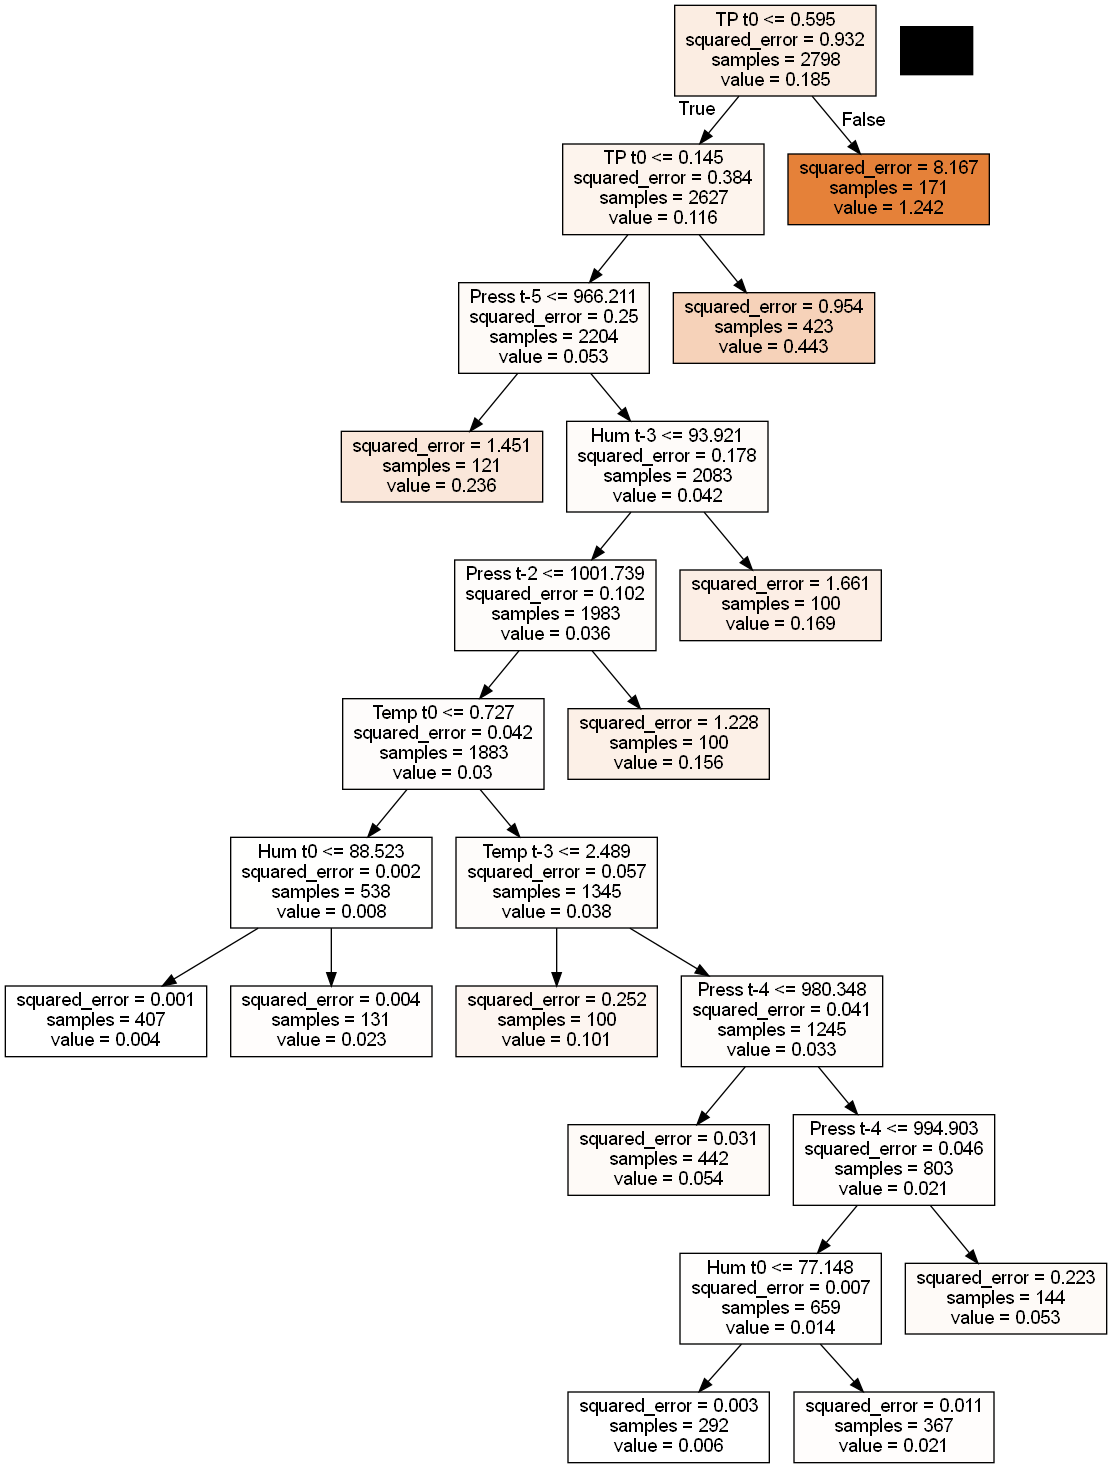

In [45]:
Image(graph.create_png())

In [46]:
graph.write_png('DT_color.png')

True